In [1]:
import os
import random
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import yaml
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
import pdb
import sys
sys.path.append('..')
from template import utils, utils_v2

In [2]:
utils_v2.save_model

<function template.utils_v2.save_model(model, optimizer, epoch, stats, margin)>

In [3]:
utils.set_random_seeds()

In [4]:
torch.use_deterministic_algorithms(False)

In [5]:
# setting config
config = yaml.safe_load(open("config.yaml"))
print(f"Our config: {config}")

Our config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 10, 'LR': '3e-4'}


In [6]:
LFWPeople_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

In [7]:
train_dataset = datasets.LFWPeople(root='./data', transform=LFWPeople_tf, split="train",download=True)
test_dataset = datasets.LFWPeople(root='./data', transform=LFWPeople_tf, split="test",download=True)
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [0.5, 0.5])

Files already downloaded and verified
Files already downloaded and verified


In [8]:
print(f"train set size: {len(train_dataset)}")
print(f"validation set size: {len(val_dataset)}")
print(f"test set size: {len(test_dataset)}")

train set size: 9525
validation set size: 1854
test set size: 1854


In [9]:
class TripletDataset:
    """
    Dataset class from which we sample random triplets
    """
    def __init__(self, dataset):
        """ Dataset initializer"""
        self.dataset = dataset
        self.arange = np.arange(len(self.dataset))
        self.labels = torch.Tensor([l for _,l in dataset])
        
        self.cleaned_dataset, self.cleaned_labels = self._clean_singular_anchors()
        self.arange_cleaned = np.arange(len(self.cleaned_dataset))
        return
    
    def __len__(self):
        """ Returning number of anchors """
        return len(self.cleaned_dataset)
    
    def _clean_singular_anchors(self):
        """ This method cleans the dataset. It deletes the samples, in which there was only one face (cannot create positive and anchor faces).
        """
        singular_anchors = []
        for i in range(len(self.dataset)):
            _ , anchor_lbl = self.dataset[i]
            pos_ids = self.arange[torch.where(self.labels == anchor_lbl)]
            if isinstance(pos_ids, np.int64):
                singular_anchors.append(i)

        self.cleaned_dataset = [self.dataset[i] for i in range(len(self.dataset)) if i not in singular_anchors]
        self.cleaned_labels = torch.Tensor([l for _,l in self.cleaned_dataset])

        return self.cleaned_dataset, self.cleaned_labels
    
    def __getitem__(self, i):
        """ 
        Sampling a triplet for the dataset. Index i corresponds to anchor 
        """
        # sampling anchor
        anchor_img, anchor_lbl = self.cleaned_dataset[i]
        
        
        # lists for positives and negatives
        pos_ids = self.arange_cleaned[torch.where(self.cleaned_labels == anchor_lbl)]
        neg_id = self.arange[torch.where(self.labels != anchor_lbl)]
        
        pos_ids = np.delete(pos_ids, 0) # Deleting anchor face from the positive faces. Anchor id is always at the beggining of an array.
        
        pos_id, neg_id = random.choice(pos_ids).item(), random.choice(neg_id).item()
        pos_img, pos_lbl = self.cleaned_dataset[pos_id] 
        neg_img, neg_lbl = self.dataset[neg_id]
              
        return (anchor_img, pos_img, neg_img), (anchor_lbl, pos_lbl, neg_lbl)

In [10]:
tri_train_dataset = TripletDataset(train_dataset)
tri_val_dataset = TripletDataset(val_dataset)
tri_test_dataset = TripletDataset(test_dataset)

There may be more subtle way to get rid of single "no positive faces except anchor" problem, f.e. making use of them in negative samples but we will try this approach in the beggining.

In [11]:
print(f"train set size after cleanup: {len(tri_train_dataset)}")
print(f"validation set size after cleanup: {len(tri_val_dataset)}")
print(f"test set size after cleanup: {len(tri_test_dataset)}")

train set size after cleanup: 6671
validation set size after cleanup: 1110
test set size after cleanup: 1065


In [12]:
def clip_img(img):
    maxValue = np.amax(img)
    minValue = np.amin(img)
    img = np.clip(img, 0, 1)
    return img

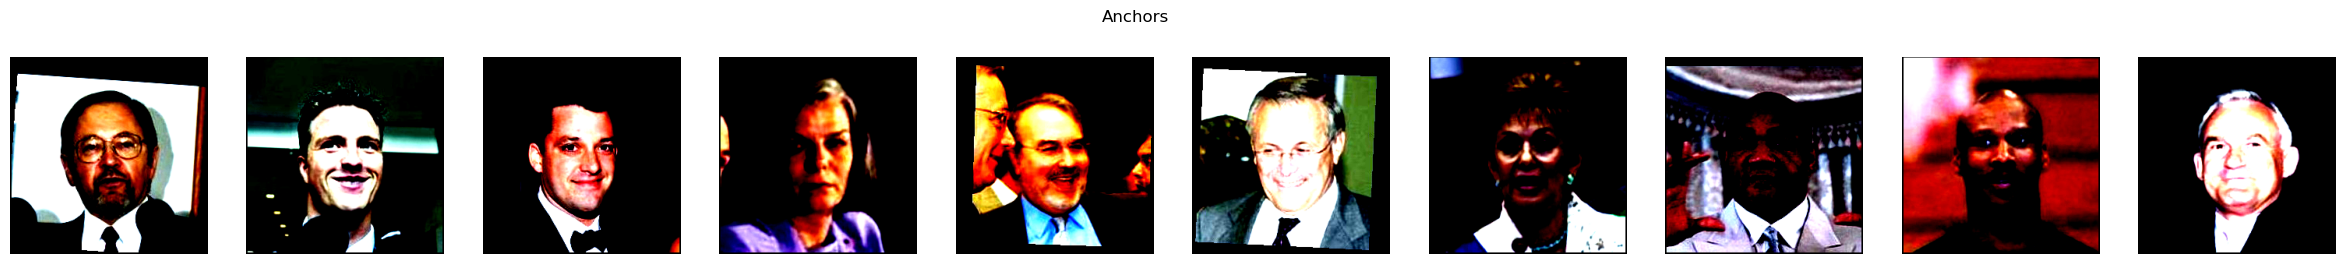

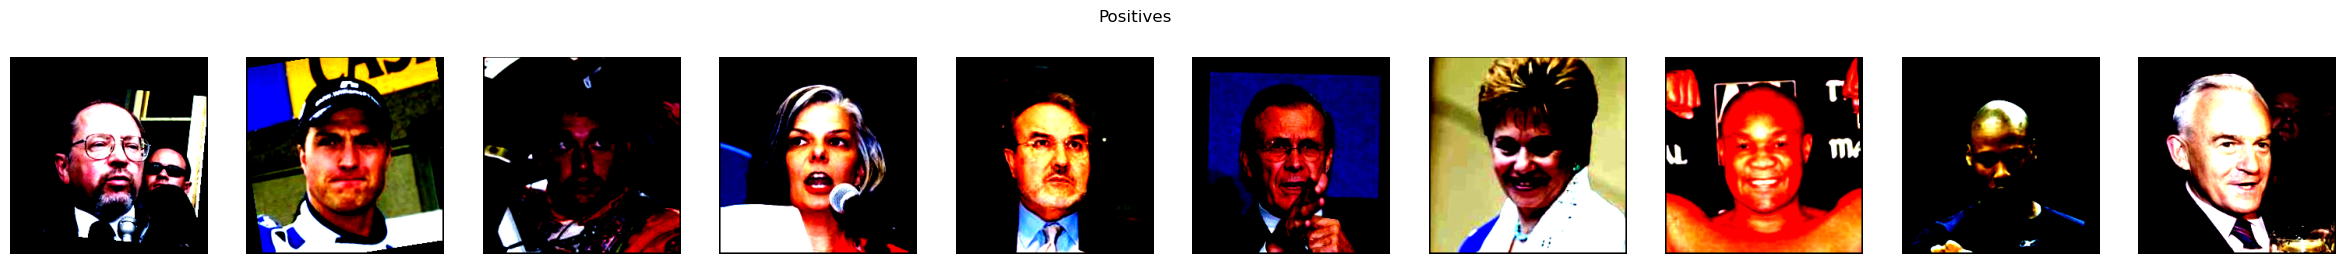

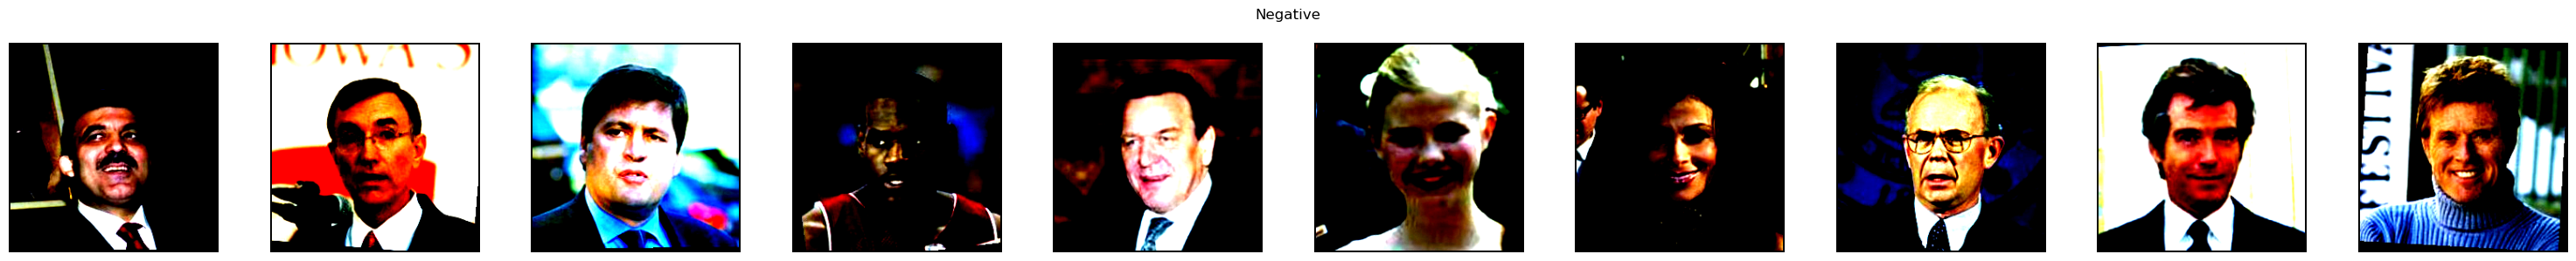

In [13]:
fig_anchors, anchors = plt.subplots(1, 10, figsize=(30,3))
fig_pos, positives = plt.subplots(1, 10, figsize=(30,3))
fig_neg, negatives = plt.subplots(1, 10, figsize=(30,3))
for i in range(10):
    try:
        (anchor, positive, negative), _ = tri_val_dataset[i]
        anchor = anchor.numpy().reshape(3,254,254).transpose(1, 2, 0)
        positive = positive.numpy().reshape(3,254,254).transpose(1, 2, 0)
        negative = negative.numpy().reshape(3,254,254).transpose(1, 2, 0)
        anchor = clip_img(anchor)
        positive = clip_img(positive)
        negative = clip_img(negative)
        anchors[i].imshow(anchor)
        anchors[i].axis("off")
        positives[i].imshow(positive)
        positives[i].axis("off")
        negatives[i].imshow(negative)
        negatives[i].axis("off")
    except ValueError:
        continue
fig_anchors.suptitle("Anchors")
fig_pos.suptitle("Positives")
fig_neg.suptitle("Negative")
plt.tight_layout()

In [14]:
batch_size = int(config["BATCH_SIZE"])

In [15]:
train_loader = torch.utils.data.DataLoader(dataset=tri_train_dataset, batch_size=batch_size, shuffle=True) 
valid_loader = torch.utils.data.DataLoader(dataset=tri_val_dataset, batch_size=batch_size, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=tri_test_dataset, batch_size=batch_size, shuffle=False) 

## Siamese model

In [16]:
class NormLayer(nn.Module):
    """ Layer that computer embedding normalization """
    def __init__(self, l=2):
        """ Layer initializer """
        assert l in [1, 2]
        super().__init__()
        self.l = l
        return
    
    def forward(self, x):
        """ Normalizing embeddings x. The shape of x is (B,D) """
        x_normalized = x / torch.norm(x, p=self.l, dim=-1, keepdim=True)
        return x_normalized

In [17]:
class SiameseModel(nn.Module):
    """ 
    Implementation of a simple siamese model 
    """
    def __init__(self, emb_dim=32, in_spatial=(32, 32), use_pretrained = True):
        """ Module initializer """
        super().__init__()
        
        # convolutional feature extractor
        resnet = models.resnet18(pretrained=use_pretrained)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
        # fully connected embedder
        self.fc = nn.Linear(512, emb_dim)
        
        # auxiliar layers
        self.flatten = nn.Flatten()
        self.norm = NormLayer()
    
        return
    
    def forward_one(self, x):
        """ Forwarding just one sample through the model """
        x = self.resnet(x)
        x_flat = self.flatten(x)
        x_emb = self.fc(x_flat)
        x_emb_norm = self.norm(x_emb)
        return x_emb_norm
    
    def forward(self, anchor, positive, negative):
        """ Forwarding a triplet """
        anchor_emb = self.forward_one(anchor)
        positive_emb = self.forward_one(positive)
        negative_emb = self.forward_one(negative)
        
        return anchor_emb, positive_emb, negative_emb

In [18]:
class SiameseModel2(nn.Module):
    """ 
    Implementation of a simple siamese model 
    """
    def __init__(self, emb_dim=32, in_spatial=(32, 32), use_pretrained = True):
        """ Module initializer """
        super().__init__()
        
        # convolutional feature extractor
        resnet = models.resnet18(pretrained=use_pretrained)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
        # fully connected embedder
        self.fc = nn.Linear(512, emb_dim)
        
        # auxiliar layers
        self.flatten = nn.Flatten()
        self.norm = NormLayer()
    
        return
    
    def forward_one(self, x):
        """ Forwarding just one sample through the model """
        x = self.resnet(x)
        x_flat = self.flatten(x)
        x_emb = self.fc(x_flat)
        x_emb_norm = self.norm(x_emb)
        return x_emb_norm
    
    def forward(self, anchor, positive):
        """ Forwarding a triplet """
        anchor_emb = self.forward_one(anchor)
        positive_emb = self.forward_one(positive)

        return anchor_emb, positive_emb

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SiameseModel2(use_pretrained = True)
model = model.to(device)

/home/user/lschulze/anaconda3/envs/lab/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/lschulze/anaconda3/envs/lab/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training
Triplet loss and Trainer shall initially remain unchanged

In [20]:
class TripletLoss(nn.Module):
    """ Implementation of the triplet loss function """
    def __init__(self, margin=0.2, reduce="mean"):
        """ Module initializer """
        assert reduce in ["mean", "sum"]
        super().__init__()
        self.margin = margin
        self.reduce = reduce
        return
        
    def forward(self, anchor, positive, negative):
        """ Computing pairwise distances and loss functions """
        # L2 distances
        d_ap = (anchor - positive).pow(2).sum(dim=-1)
        d_an = (anchor - negative).pow(2).sum(dim=-1)
        
        # triplet loss function
        loss = (d_ap - d_an + self.margin)
        loss = torch.maximum(loss, torch.zeros_like(loss))
        
        # averaging or summing      
        loss = torch.mean(loss) if(self.reduce == "mean") else torch.sum(loss)
      
        return loss

In [28]:
class SemiHardTripletLoss(nn.Module):
    """ Implementation of the triplet loss function """
    def __init__(self, margin=0.2, reduce="mean"):
        """ Module initializer """
        assert reduce in ["mean", "sum"]
        super().__init__()
        self.margin = margin
        self.reduce = reduce
        return
        
    def forward(self, anchor, positive, labels):
        """
        Compute the TripletLoss using semi-hard negative mining strategy.
        This function is vectorized and does not contain explicit for loops.
        """
        # Compute distance of positive examples
        d_ap = (anchor - positive).pow(2).sum(dim=-1)
        # Compute pairwise distance between the anchors
        anchor_pairwise_dist = torch.cdist(anchor, positive, p=2)

        # Create a large diagonal matrix 
        diag = torch.eye(len(anchor)).to(anchor.device) * 1e6

        # Add it to the pairwise distance to ignore diagonal values when calculating minimum
        anchor_pairwise_dist = anchor_pairwise_dist + diag

        # Compute minimum distance of the other anchors meeting the given requirements
        mask = (anchor_pairwise_dist > d_ap.unsqueeze(1)) & (labels != labels.unsqueeze(1))
        d_an, _ = torch.where(mask, anchor_pairwise_dist, 1e6).min(dim=1)

        # triplet loss function
        loss = (d_ap - d_an + self.margin)
        loss = torch.maximum(loss, torch.zeros_like(loss))

        # averaging or summing      
        loss = torch.mean(loss) if(self.reduce == "mean") else torch.sum(loss)

        return loss

In [29]:
# class SemiHardTripletDataset:
#     """
#     Dataset class from which we sample random triplets
#     """
#     def __init__(self, dataset, model, margin  = 0.2):
#         """ Dataset initializer"""
#         self.dataset = dataset
#         self.arange = np.arange(len(self.dataset))
#         self.labels = torch.Tensor([l for _,l in dataset])
        
#         self.cleaned_dataset, self.cleaned_labels = self._clean_singular_anchors()
#         self.arange_cleaned = np.arange(len(self.cleaned_dataset))

#         self.embedding_model = model
#         self.margin = margin
#         return
    
#     def __len__(self):
#         """ Returning number of anchors """
#         return len(self.cleaned_dataset)
    
#     def _clean_singular_anchors(self):
#         """ This method cleans the dataset. It deletes the samples, in which there was only one face (cannot create positive and anchor faces).
#         """
#         singular_anchors = []
#         for i in range(len(self.dataset)):
#             _ , anchor_lbl = self.dataset[i]
#             pos_ids = self.arange[torch.where(self.labels == anchor_lbl)]
#             if isinstance(pos_ids, np.int64):
#                 singular_anchors.append(i)

#         self.cleaned_dataset = [self.dataset[i] for i in range(len(self.dataset)) if i not in singular_anchors]
#         self.cleaned_labels = torch.Tensor([l for _,l in self.cleaned_dataset])

#         return self.cleaned_dataset, self.cleaned_labels
    
#     def __getitem__(self, i):
#         """ 
#         Sampling a triplet for the dataset. Index i corresponds to anchor 
#         """
#         # sampling anchor
#         anchor_img, anchor_lbl = self.cleaned_dataset[i]
        
        
#         # lists for positives and negatives
#         pos_ids = self.arange_cleaned[torch.where(self.cleaned_labels == anchor_lbl)]
#         neg_ids = self.arange[torch.where(self.labels != anchor_lbl)]
#         pos_ids = np.delete(pos_ids, 0) # Deleting anchor face from the positive faces. Anchor id is always at the beggining of an array.

#         # Calculate instance, such that neg_distance to anchor is larger than pos_distance
#         # This is horribly inefficient, considering we do not use batch wise operations
#         with torch.no_grad():
#             self.model = self.model.eval()
#             for pos_id in pos_ids:
#                 positive, pos_lbl = self.cleaned_dataset[pos_id]
#                 for neg_id in neg_ids:
#                     negative, neg_lbl  = self.dataset[neg_id]
#                     # L2 distances
#                     d_ap = (anchor_img - positive).pow(2).sum(dim=-1)
#                     d_an = (anchor - negative).pow(2).sum(dim=-1)
                    
#                     if d_an > d_ap and d_an < self.margin:
#                         return (anchor_img, positive, negative), (anchor_lbl, pos_lbl, neg_lbl)


            

#         self.model = self.model.train()

#         print("No triplet could be found")
#         pos_id, neg_id = random.choice(pos_ids).item(), random.choice(neg_ids).item()
#         pos_img, pos_lbl = self.cleaned_dataset[pos_id] 
#         neg_img, neg_lbl = self.dataset[neg_id]
              
#         return (anchor_img, pos_img, neg_img), (anchor_lbl, pos_lbl, neg_lbl)

In [30]:
class Trainer2:
    """
    Class for training and validating a siamese model
    """
    
    def __init__(self, model, criterion, train_loader, valid_loader, n_iters=1e4, save_freq = 500, margin = 0.2, save_name='siamese'):
        """ Trainer initializer """
        self.model = model
        self.criterion = criterion
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        
        self.n_iters = int(n_iters)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        self.save_name = save_name
        self.margin = 0.2
        self.save_freq = save_freq
        self.train_loss = []
        self.valid_loss = []
        return
    
    @torch.no_grad()
    def valid_step(self, val_iters=100):
        """ Some validation iterations """
        self.model.eval()
        cur_losses = []
        for i, ((anchors, positives, negatives), (labels, _, _)) in enumerate(self.valid_loader):   
            # setting inputs to GPU
            anchors = anchors.to(self.device)
            positives = positives.to(self.device)
            negatives = negatives.to(self.device)
            labels = labels.to(device)
            
            # forward pass and triplet loss
            anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
            loss = self.criterion(anchor_emb, positive_emb, negative_emb, labels)
            cur_losses.append(loss.item())
            
            if(i >= val_iters):
                break
    
        self.valid_loss += cur_losses
        self.model.train()
        
        return cur_losses
    
    def fit(self):
        """ Train/Validation loop """
        
        self.iter_ = 0
        progress_bar = tqdm(total=self.n_iters, initial=0)
        
        for i in range(self.n_iters):
            for (anchors, positives, negatives), (labels, pos_labels, _) in self.train_loader:    
                # setting inputs to GPU
                anchors = anchors.to(self.device)
                positives = positives.to(self.device)
                labels = labels.to(device)
                
                # forward pass and triplet loss
                anchor_emb, positive_emb = self.model(anchors, positives)
                loss = self.criterion(anchor_emb, positive_emb, labels)
                self.train_loss.append(loss.item())
                
                # optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
                # updating progress bar
                progress_bar.set_description(f"Train Iter {self.iter_}: Loss={round(loss.item(),5)})")
                
                # doing some validation every once in a while
                if(self.iter_ % 250 == 0):
                    cur_losses = self.valid_step()
                    print(f"Valid loss @ iteration {self.iter_}: Loss={np.mean(cur_losses)}")
                # saving model every n-th iter
                if(self.iter_ % self.save_freq == 0):
                    stats = {
                    "train_loss": self.train_loss,
                    "valid_loss": self.valid_loss
                    }
                #    utils_v2.save_model(self.model, self.optimizer, self.iter_, stats, margin=self.margin, name=self.save_name)
                self.iter_ = self.iter_+1 
                if(self.iter_ >= self.n_iters):
                    break
            if(self.iter_ >= self.n_iters):
                break
        return

In [31]:
# criterion = TripletLoss(margin=0.2)
criterion = SemiHardTripletLoss(margin=0.2)

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SiameseModel2(use_pretrained = True)
model = model.to(device)
trainer = Trainer2(model=model, criterion=criterion, train_loader=train_loader, valid_loader=valid_loader, n_iters=10001, save_freq = 500, save_name = 'rand_weights')
# train_loader_semihard = torch.utils.data.DataLoader(dataset=tri_train_dataset, batch_size=128, shuffle=True) 

In [33]:
torch.cuda.empty_cache()

In [34]:
trainer.fit()


Train Iter 0: Loss=0.10852):   0%|          | 0/10001 [00:00<?, ?it/s]

This is the mask shape torch.Size([64, 64])
tensor([[False,  True,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True, False,  True],
        [ True,  True, False,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ..., False,  True,  True],
        [ True, False,  True,  ...,  True, False,  True],
        [False, False, False,  ..., False, False, False]], device='cuda:0')


TypeError: SiameseModel2.forward() takes 3 positional arguments but 4 were given

In [ ]:
@torch.no_grad()
def test_model(model, test_loader, criterion, device = "cuda"):
    """ Some test iterations """
    model.eval()
    cur_losses = []
    for i, ((anchors, positives, negatives),_) in enumerate(test_loader):   
        # setting inputs to GPU
        anchors = anchors.to(device)
        positives = positives.to(device)
        negatives = negatives.to(device)
        
        # forward pass and triplet loss
        anchor_emb, positive_emb, negative_emb = model(anchors, positives, negatives)
        loss = criterion(anchor_emb, positive_emb, negative_emb)
        cur_losses.append(loss.item())
    return np.mean(cur_losses)

## Random weights; embed_size=32; margin=0.2

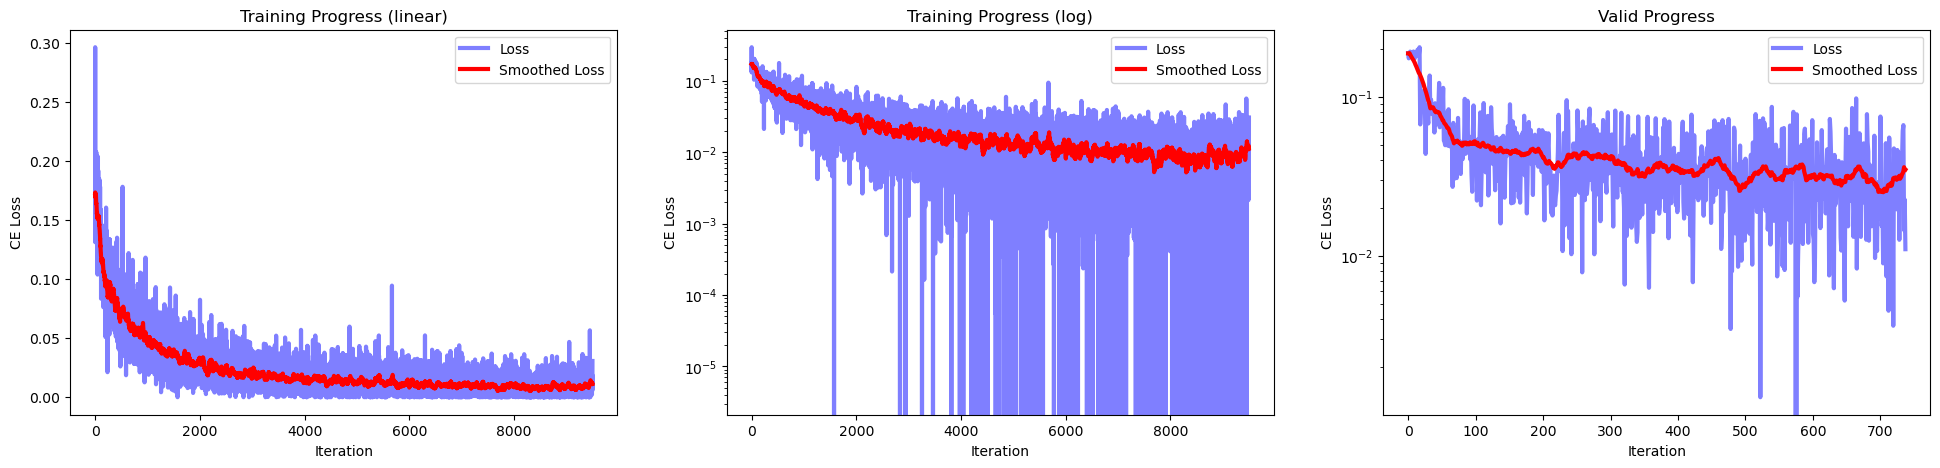

In [ ]:
utils_v2.visualize_progress(trainer.train_loss[:9500], trainer.valid_loss[:9500], start=0)

In [ ]:
print(f"Loss for the test set: {test_model(trainer.model, test_loader, criterion, device)}")

Loss for the test set: 0.04594797717736048


## Training finetuned (pretrained weights); embed_size=32; margin=0.2

In [ ]:
model, optimizer, epoch, stats = utils_v2.load_model(trainer.model, trainer.optimizer, savepath="checkpoints/checkpoint_epoch_9500_margin_0.2.pth")

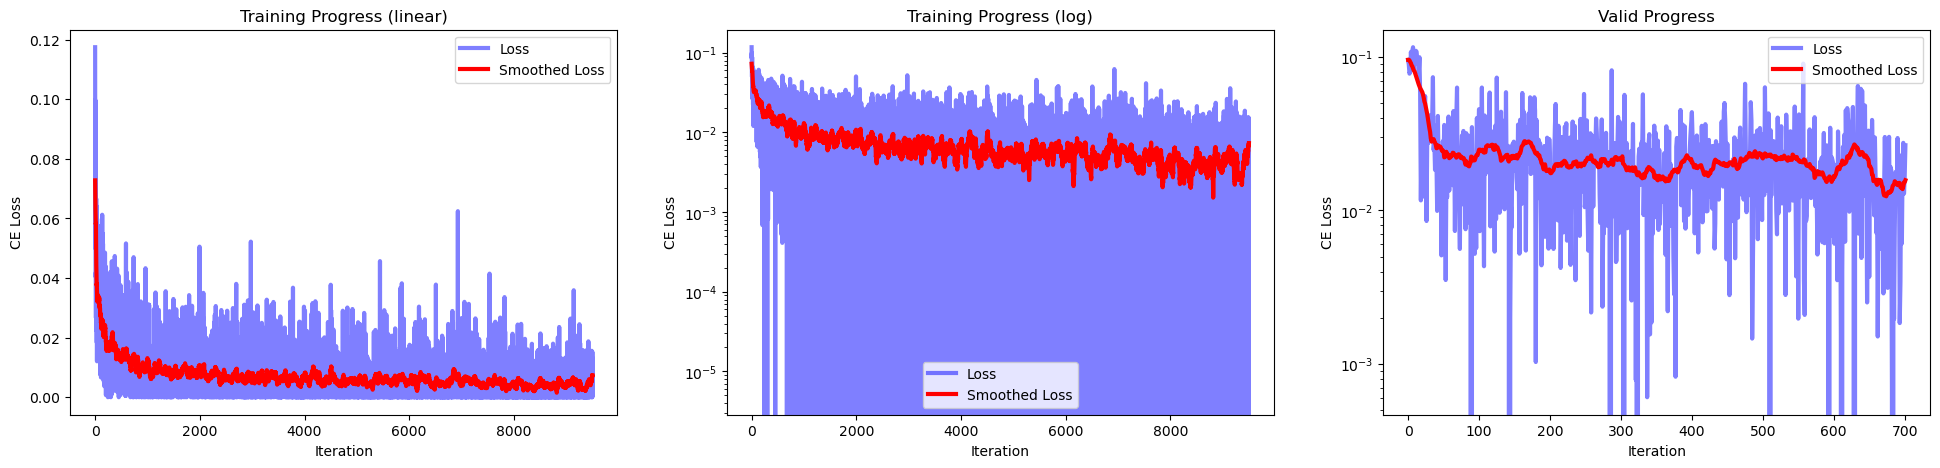

In [ ]:
utils_v2.visualize_progress(stats["train_loss"], stats["valid_loss"], start=0)

In [ ]:
print(f"Loss for the test set: {test_model(model, test_loader, criterion, device)}")

Loss for the test set: 0.017512838678764336


In the training progress plot, we can see that loss more often that not is equal to 0 (that's why blue loss curve drops all the way down). This is a good sign of training, because it states that positive samples are within the margin and negative ones are outside the margin, thus faces are correctly classified

## Semi-hard training of a better model

In [ ]:
class SemiHardTrainer:
    """
    Class for training and validating a siamese model
    """
    
    def __init__(self, model, criterion, train_loader, valid_loader, n_iters=1e4, save_freq = 500, margin = 0.2, save_name='siamese'):
        """ Trainer initializer """
        self.model = model
        self.criterion = criterion
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        
        self.n_iters = int(n_iters)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        self.save_name = save_name
        self.margin = 0.2
        self.save_freq = save_freq
        self.train_loss = []
        self.valid_loss = []
        return
    
    @torch.no_grad()
    def valid_step(self, val_iters=100):
        """ Some validation iterations """
        self.model.eval()
        cur_losses = []
        for i, ((anchors, positives, negatives), _) in enumerate(self.valid_loader):   
            # setting inputs to GPU
            anchors = anchors.to(self.device)
            positives = positives.to(self.device)
            negatives = negatives.to(self.device)
            # labels = torch.cat((anchor_lbls, pos_lbls, neg_lbls), dim=0)
            # forward pass and triplet loss
            anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
            # all_embeddings = torch.cat((anchor_emb, positive_emb, negative_emb), dim=0)
            hardest_positive_dist, hardest_negative_dist, hardest_negative_emb = self.get_triplets(anchor_emb, positive_emb, negative_emb)
            loss = self.criterion(anchor_emb, positive_emb, hardest_negative_emb)
            cur_losses.append(loss.item())
            
            if(i >= val_iters):
                break
    
        self.valid_loss += cur_losses
        self.model.train()
        
        return cur_losses
    def get_triplets(self, anchor_emb, positive_emb, negative_emb):
        """
        Function to generate triplets based on semi-hard negative mining strategy.
        """
        # pdb.set_trace()
        # Calculate pairwise distances in embedding space
        pairwise_dist = torch.cdist(anchor_emb, anchor_emb, p=2)

        # For each anchor-positive pair, compute the distance
        anchor_positive_dist = (anchor_emb - positive_emb).pow(2).sum(dim=-1)

        # Compute a mask for all hard negatives
        mask_hard_negative = pairwise_dist < (anchor_positive_dist.unsqueeze(1) + self.margin) # "+ self.margin" makes it semi-hard negative mining. 

        # For each anchor, find the hardest negative
        anchor_negative_dist = pairwise_dist + 1e6 * (1 - mask_hard_negative.float())
        hardest_negative_dist, hardest_negative = anchor_negative_dist.min(1, keepdim=True)

        # Get the embeddings of the hardest negatives
        hardest_negative_emb = negative_emb[hardest_negative.squeeze()]

        return anchor_positive_dist, hardest_negative_dist, hardest_negative_emb
    def fit(self):
        """ Train/Validation loop """
        
        self.iter_ = 0
        progress_bar = tqdm(total=self.n_iters, initial=0)
        
        for i in range(self.n_iters):
            for (anchors, positives, negatives), _ in self.train_loader:    
                # setting inputs to GPU
                anchors = anchors.to(self.device)
                positives = positives.to(self.device)
                negatives = negatives.to(self.device)
                # labels = torch.cat((anchor_lbls, pos_lbls, neg_lbls), dim=0)
                # forward pass and triplet loss
                anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
                # all_embeddings = torch.cat((anchor_emb, positive_emb, negative_emb), dim=0)
                hardest_positive_dist, hardest_negative_dist, hardest_negative_emb = self.get_triplets(anchor_emb, positive_emb, negative_emb)
                loss = self.criterion(anchor_emb, positive_emb, hardest_negative_emb)
                self.train_loss.append(loss.item())
                
                # optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
                # updating progress bar
                progress_bar.set_description(f"Train Iter {self.iter_}: Loss={round(loss.item(),5)})")
                
                # doing some validation every once in a while
                if(self.iter_ % 250 == 0):
                    cur_losses = self.valid_step()
                    print(f"Valid loss @ iteration {self.iter_}: Loss={np.mean(cur_losses)}")
                # saving model every n-th iter
                if(self.iter_ % self.save_freq == 0):
                    stats = {
                    "train_loss": self.train_loss,
                    "valid_loss": self.valid_loss
                    }
                    utils_v2.save_model(self.model, self.optimizer, self.iter_, stats, margin=self.margin, name=self.save_name)
                self.iter_ = self.iter_+1 
                if(self.iter_ >= self.n_iters):
                    break
            if(self.iter_ >= self.n_iters):
                break
        return

In [ ]:
# Have to redefine dataloaders because if the batch size is too small, there might not be enough negatives in a batch for the semi-hard condition to be satisfied.

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=tri_train_dataset, batch_size=128, shuffle=True) 
valid_loader = torch.utils.data.DataLoader(dataset=tri_val_dataset, batch_size=128, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=tri_test_dataset, batch_size=128, shuffle=False) 

In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = "cuda"
model = SiameseModel(use_pretrained = True) # w/pretrained was better
model = model.to(device)

/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = TripletLoss(margin=0.2) # changed criterion
trainer_shard = SemiHardTrainer(model=model, criterion=criterion, train_loader=train_loader, valid_loader=valid_loader, n_iters=4001, save_freq = 500, save_name = 'semihard_6k') #only 4k iters, because we load a model trained on 6k iters

In [ ]:
# trainer_shard.fit()

Train Iter 0: Loss=0.13788):   0%|                                                            | 0/10001 [00:01<?, ?it/s]

Valid loss @ iteration 0: Loss=0.09063652157783508


Train Iter 250: Loss=0.00511):   0%|                                                          | 0/10001 [03:52<?, ?it/s]

Valid loss @ iteration 250: Loss=0.02135220542550087


Train Iter 500: Loss=0.01076):   0%|                                                          | 0/10001 [07:37<?, ?it/s]

Valid loss @ iteration 500: Loss=0.022602517985635333


Train Iter 750: Loss=0.00991):   0%|                                                          | 0/10001 [10:24<?, ?it/s]

Valid loss @ iteration 750: Loss=0.02349506618662013


Train Iter 1000: Loss=0.00489):   0%|                                                         | 0/10001 [13:01<?, ?it/s]

Valid loss @ iteration 1000: Loss=0.020588884647521708


Train Iter 1250: Loss=0.00647):   0%|                                                         | 0/10001 [15:34<?, ?it/s]

Valid loss @ iteration 1250: Loss=0.02026232647606068


Train Iter 1500: Loss=0.00661):   0%|                                                         | 0/10001 [18:08<?, ?it/s]

Valid loss @ iteration 1500: Loss=0.016210711819844112


Train Iter 1750: Loss=0.00351):   0%|                                                         | 0/10001 [20:40<?, ?it/s]

Valid loss @ iteration 1750: Loss=0.023578124172571633


Train Iter 2000: Loss=0.00669):   0%|                                                         | 0/10001 [23:17<?, ?it/s]

Valid loss @ iteration 2000: Loss=0.01844892981979582


Train Iter 2250: Loss=0.00445):   0%|                                                         | 0/10001 [25:59<?, ?it/s]

Valid loss @ iteration 2250: Loss=0.01874490516881148


Train Iter 2500: Loss=0.0076):   0%|                                                          | 0/10001 [28:29<?, ?it/s]

Valid loss @ iteration 2500: Loss=0.0183661917431487


Train Iter 2750: Loss=0.00522):   0%|                                                         | 0/10001 [31:00<?, ?it/s]

Valid loss @ iteration 2750: Loss=0.01731345026443402


Train Iter 3000: Loss=0.00585):   0%|                                                         | 0/10001 [33:29<?, ?it/s]

Valid loss @ iteration 3000: Loss=0.015684681116706796


Train Iter 3250: Loss=0.01159):   0%|                                                         | 0/10001 [35:59<?, ?it/s]

Valid loss @ iteration 3250: Loss=0.02159149820605914


Train Iter 3500: Loss=0.00896):   0%|                                                         | 0/10001 [38:28<?, ?it/s]

Valid loss @ iteration 3500: Loss=0.01431333382303516


Train Iter 3750: Loss=0.0108):   0%|                                                          | 0/10001 [40:59<?, ?it/s]

Valid loss @ iteration 3750: Loss=0.016293713202079136


Train Iter 4000: Loss=0.00646):   0%|                                                         | 0/10001 [43:28<?, ?it/s]

Valid loss @ iteration 4000: Loss=0.01614203490316868


Train Iter 4250: Loss=0.00747):   0%|                                                         | 0/10001 [45:59<?, ?it/s]

Valid loss @ iteration 4250: Loss=0.013425455066478915


Train Iter 4500: Loss=0.0021):   0%|                                                          | 0/10001 [48:29<?, ?it/s]

Valid loss @ iteration 4500: Loss=0.010784317351256808


Train Iter 4750: Loss=0.0008):   0%|                                                          | 0/10001 [50:59<?, ?it/s]

Valid loss @ iteration 4750: Loss=0.011344489253436526


Train Iter 5000: Loss=0.02006):   0%|                                                         | 0/10001 [53:28<?, ?it/s]

Valid loss @ iteration 5000: Loss=0.03348888705174128


Train Iter 5250: Loss=0.00845):   0%|                                                         | 0/10001 [55:58<?, ?it/s]

Valid loss @ iteration 5250: Loss=0.03173380365802182


Train Iter 5500: Loss=0.0039):   0%|                                                          | 0/10001 [58:27<?, ?it/s]

Valid loss @ iteration 5500: Loss=0.020204066919783752


Train Iter 5750: Loss=0.0009):   0%|                                                        | 0/10001 [1:00:58<?, ?it/s]

Valid loss @ iteration 5750: Loss=0.014078977698874142


Train Iter 6000: Loss=0.00602):   0%|                                                       | 0/10001 [1:03:27<?, ?it/s]

Valid loss @ iteration 6000: Loss=0.013521834535317289


Train Iter 6076: Loss=0.00078):   0%|                                                       | 0/10001 [1:04:16<?, ?it/s]

In [ ]:
# resuming training, since my PC crashed lmao
model, optimizer, epoch, stats = utils_v2.load_model(trainer_shard.model, trainer_shard.optimizer, savepath="checkpoints/checkpoint_semihard_epoch_6000_margin_0.2.pth")


In [ ]:
trainer_shard.train_loss = stats["train_loss"]
trainer_shard.valid_loss = stats["valid_loss"]
trainer_shard.model = model
trainer_shard.optimizer = optimizer

In [ ]:
trainer_shard.fit()

Train Iter 0: Loss=0.00109):   0%|                                                             | 0/4001 [00:01<?, ?it/s]

Valid loss @ iteration 0: Loss=0.016303581444339618


Train Iter 250: Loss=0.00058):   0%|                                                           | 0/4001 [02:30<?, ?it/s]

Valid loss @ iteration 250: Loss=0.012939626118168235


Train Iter 500: Loss=0.00034):   0%|                                                           | 0/4001 [04:58<?, ?it/s]

Valid loss @ iteration 500: Loss=0.014275793917477131


Train Iter 750: Loss=0.0046):   0%|                                                            | 0/4001 [07:28<?, ?it/s]

Valid loss @ iteration 750: Loss=0.014303350096775426


Train Iter 1000: Loss=0.00268):   0%|                                                          | 0/4001 [09:57<?, ?it/s]

Valid loss @ iteration 1000: Loss=0.024401098696721926


Train Iter 1250: Loss=0.00302):   0%|                                                          | 0/4001 [12:27<?, ?it/s]

Valid loss @ iteration 1250: Loss=0.01377430252937807


Train Iter 1500: Loss=0.00507):   0%|                                                          | 0/4001 [14:56<?, ?it/s]

Valid loss @ iteration 1500: Loss=0.01369444839656353


Train Iter 1750: Loss=0.0054):   0%|                                                           | 0/4001 [17:26<?, ?it/s]

Valid loss @ iteration 1750: Loss=0.01789008325431496


Train Iter 2000: Loss=0.00522):   0%|                                                          | 0/4001 [19:55<?, ?it/s]

Valid loss @ iteration 2000: Loss=0.024799489312701754


Train Iter 2250: Loss=0.00175):   0%|                                                          | 0/4001 [22:25<?, ?it/s]

Valid loss @ iteration 2250: Loss=0.023583468256725207


Train Iter 2500: Loss=0.00077):   0%|                                                          | 0/4001 [24:54<?, ?it/s]

Valid loss @ iteration 2500: Loss=0.021194605363739863


Train Iter 2750: Loss=0.00746):   0%|                                                          | 0/4001 [27:24<?, ?it/s]

Valid loss @ iteration 2750: Loss=0.016660725697875023


Train Iter 3000: Loss=0.00013):   0%|                                                          | 0/4001 [29:53<?, ?it/s]

Valid loss @ iteration 3000: Loss=0.013356634066440165


Train Iter 3250: Loss=0.0):   0%|                                                              | 0/4001 [32:22<?, ?it/s]

Valid loss @ iteration 3250: Loss=0.01599674408013622


Train Iter 3500: Loss=0.00107):   0%|                                                          | 0/4001 [34:51<?, ?it/s]

Valid loss @ iteration 3500: Loss=0.016857331411706075


Train Iter 3750: Loss=0.00462):   0%|                                                          | 0/4001 [37:20<?, ?it/s]

Valid loss @ iteration 3750: Loss=0.016888266946706507


Train Iter 4000: Loss=0.00092):   0%|                                                          | 0/4001 [39:52<?, ?it/s]

Valid loss @ iteration 4000: Loss=0.0194724609868394


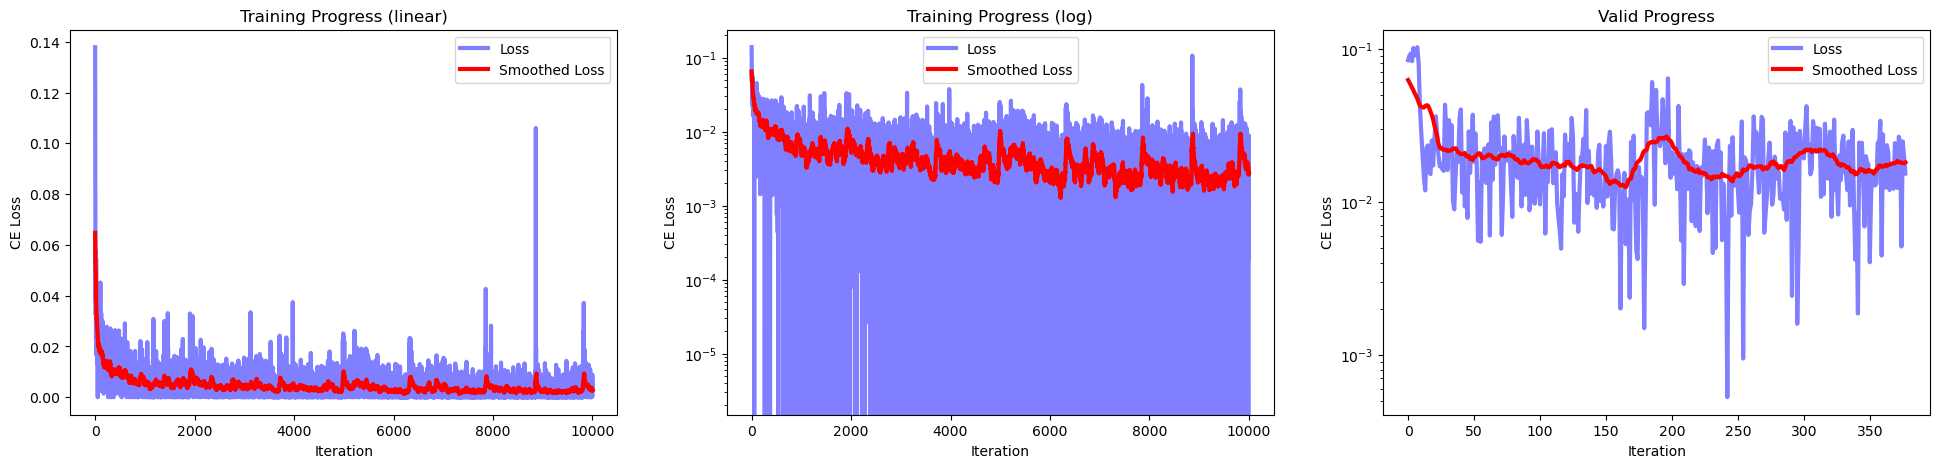

In [ ]:
utils_v2.visualize_progress(trainer_shard.train_loss, trainer_shard.valid_loss, start=0)

In [ ]:
print(f"Loss for the test set: {test_model(trainer_shard.model, test_loader, criterion, device)}")

Loss for the test set: 0.02015742550914486


We can see, that around 4500 iter/epoch, loss is at its lowest. Let's load and test the model, which was saved at 4500 iter

In [ ]:
model_4500, optimizer_4500, epoch_4500, stats_4500 = utils_v2.load_model(trainer_shard.model, trainer_shard.optimizer, savepath="checkpoints/checkpoint_semihard_epoch_4500_margin_0.2.pth")

In [ ]:
print(f"Loss for the test set: {test_model(model_4500, test_loader, criterion, device)}")

Loss for the test set: 0.01488266592948801


Test loss is even lower. It may be possible that after 4500 epoch, the model started overfitting, thus increasing valid loss

# Visualize Embeddings

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [ ]:
# model = trainer.model
device = trainer.device
model = model.eval()

In [ ]:
labels = torch.Tensor([l for _,l in test_dataset])
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
test_dataset = datasets.LFWPeople(root='./data', transform=LFWPeople_tf, split="test",download=True)

# Filtering out labels, which occur more than k times in the test dataset
k = 25
max_label = int(torch.max(labels).item())
same_labels = []
same_tensors = []
for label in range(max_label):
    indices = torch.where(labels == label)
    if len(indices[0]) > k:
        selected_tensors = [test_dataset[i][0] for i in indices[0]]
        selected_tensors_labels = [test_dataset[i][1] for i in indices[0]]
        same_tensors.append(torch.stack(selected_tensors))
        same_labels += selected_tensors_labels
    
embeddings = [model.forward_one(same_tensors[i].to(device)).cpu().detach() for i in range(len(same_tensors))]
imgs_flat = torch.cat(same_tensors).flatten().cpu().detach()

print(np.unique(same_labels).__len__())

Files already downloaded and verified
11


In [ ]:
visualization_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

embs = list()
labels = list()
imgs_flat = list()

with torch.no_grad():
    for data, label in visualization_loader:
        data = data.to(device)
        data_embedding = model.forward_one(data)

        labels.append(label)
        embs.append(data_embedding.cpu().flatten(1))
        imgs_flat.append(data.cpu().flatten(1))

labels = np.concatenate(labels)
embs = np.concatenate(embs)
imgs_flat = np.concatenate(imgs_flat)

In [ ]:

assert 0 not in same_labels, "0 in same_labels change the label of the undefined cluster"

filtered_labels = [int(labels[i].item()) if labels[i] in same_labels else 0 for i in range(labels.__len__())]

In [ ]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)
pca_embs = PCA(n_components=2).fit_transform(embs)

'''
pca_imgs_object = PCA(n_components=2).fit(imgs_flat)
pca_embs_object = PCA(n_components=2).fit(embs)
'''


'\npca_imgs_object = PCA(n_components=2).fit(imgs_flat)\npca_embs_object = PCA(n_components=2).fit(embs)\n'

In [ ]:
np.unique(filtered_labels).__len__()

12

In [ ]:
def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    COLORS = ['grey', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'r',
              'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(i)], c=COLORS[i])
    ax.legend(loc="best")

/tmp/ipykernel_2858654/734107461.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


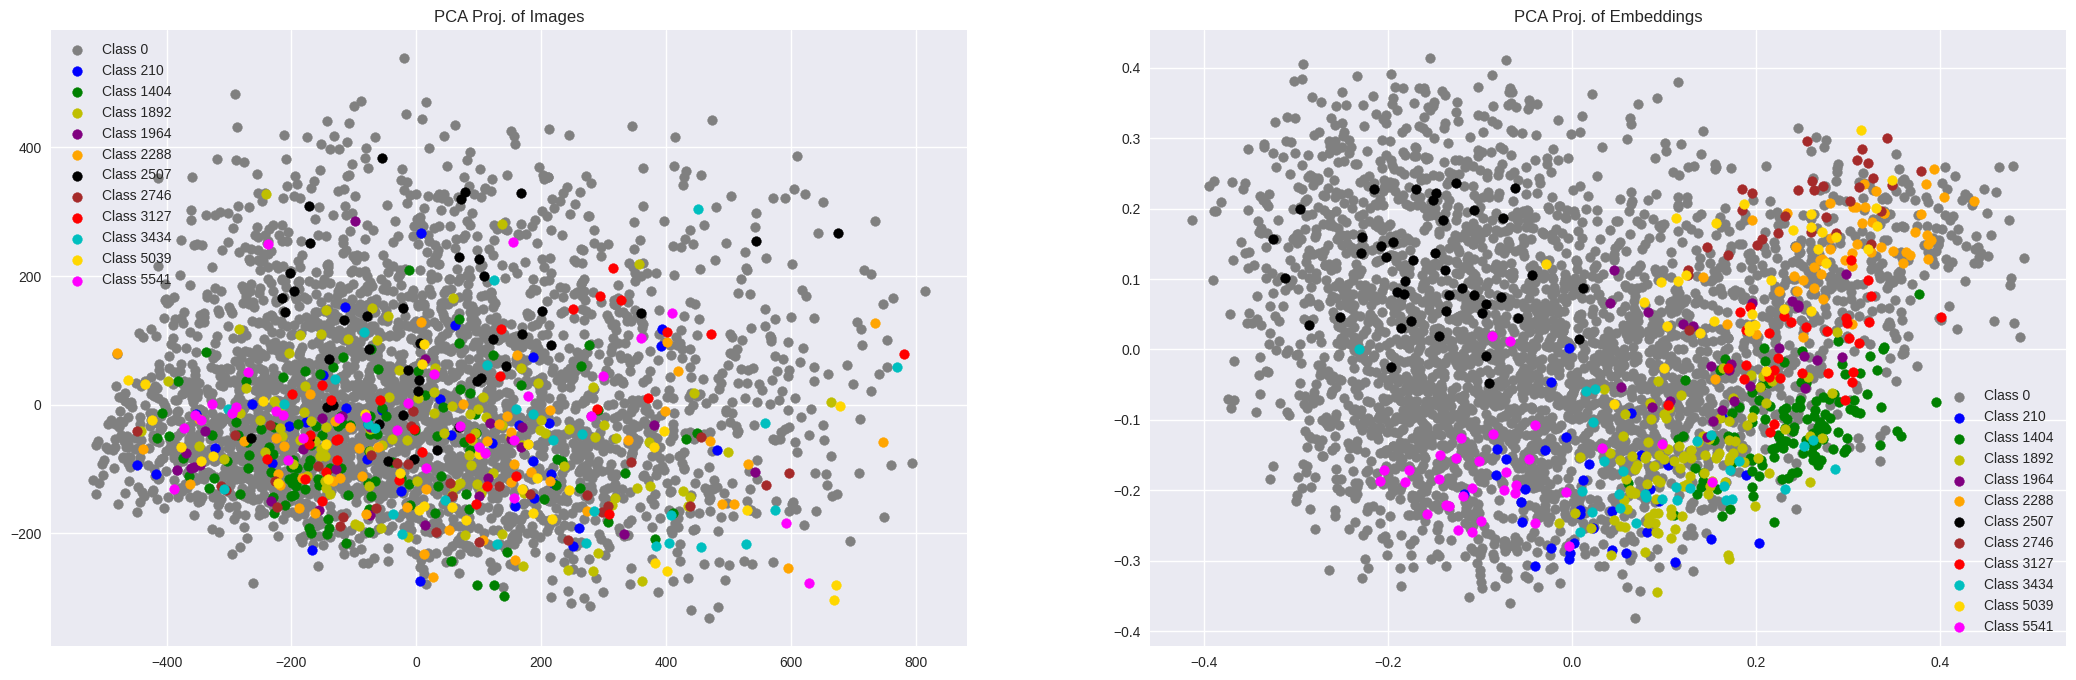

In [ ]:
N = 5000
plt.style.use('seaborn')
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], filtered_labels[:N], ax=ax[0])
ax[0].set_title("PCA Proj. of Images")
display_projections(pca_embs[:N], filtered_labels[:N], ax=ax[1])
ax[1].set_title("PCA Proj. of Embeddings")
plt.show()

In [ ]:
N = 2000
tsne_imgs = TSNE(n_components=2).fit_transform(imgs_flat[:N])
tsne_embs = TSNE(n_components=2).fit_transform(embs[:N])

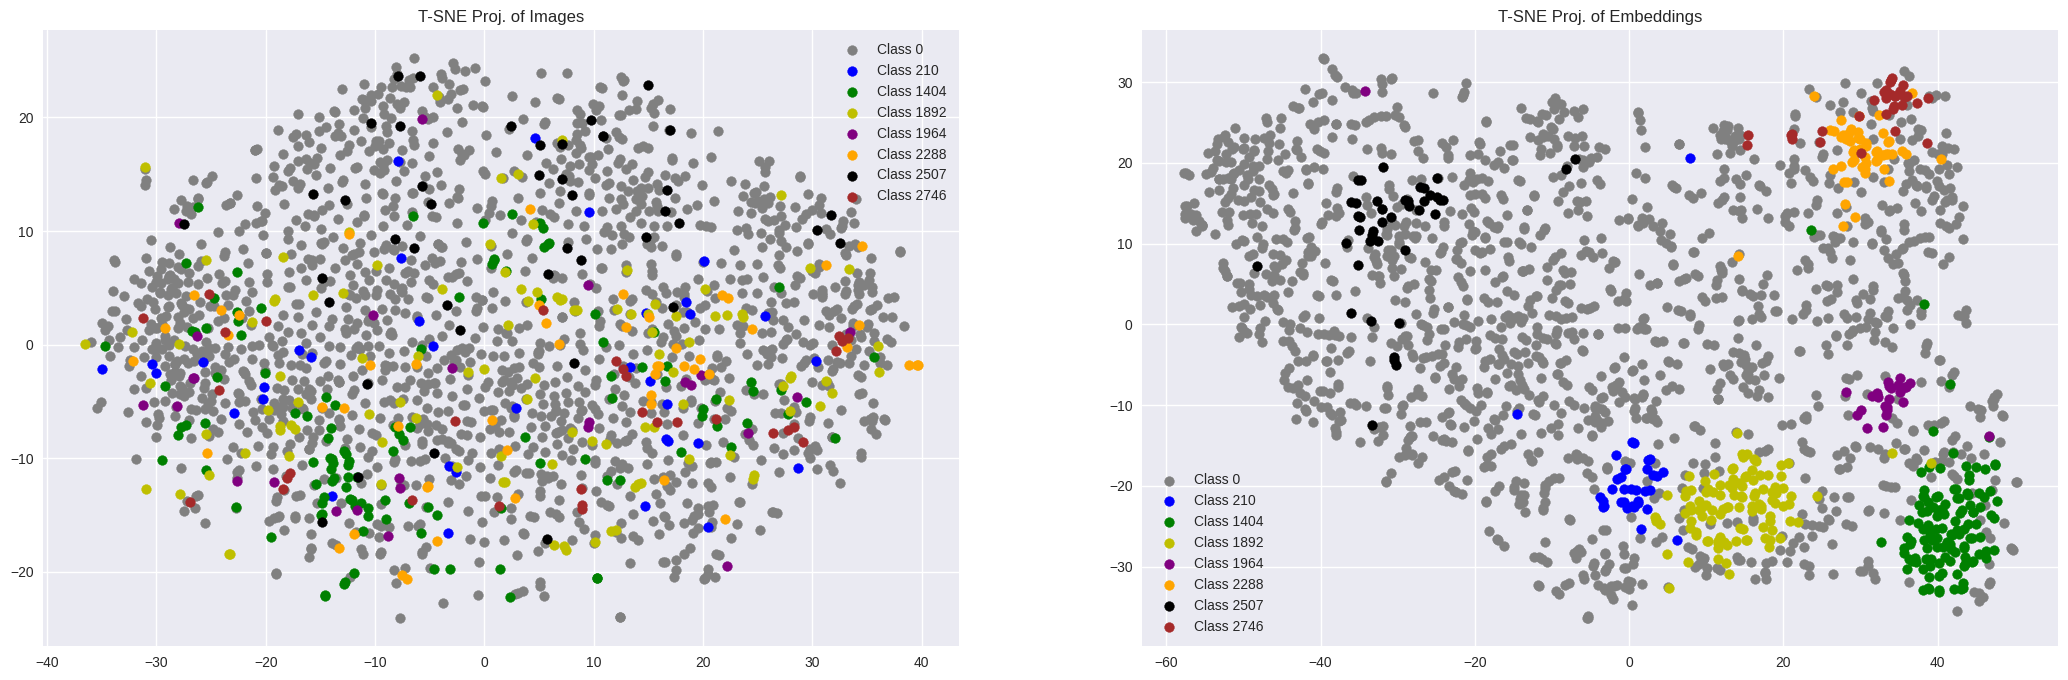

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:N], filtered_labels[:N], ax=ax[0])
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_embs[:N], filtered_labels[:N], ax=ax[1])
ax[1].set_title("T-SNE Proj. of Embeddings")
plt.show()

In [ ]:

# This code is not needed anymore
'''
def display_projections_no_labels(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
              'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)
        ax.scatter(points[idx, 0], points[idx, 1])
    ax.legend(loc="best")

    

labels = torch.Tensor([l for _,l in test_dataset])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
max_label = int(torch.max(labels).item())

same_labels = []
same_tensors = []
for label in range(max_label):
    indices = torch.where(labels == label)
    if len(indices[0]) > 10:
        selected_tensors = [test_dataset[i][0] for i in indices[0]]
        selected_tensors_labels = [test_dataset[i][1] for i in indices [0]]
        same_tensors.append(torch.stack(selected_tensors))
        same_labels += selected_tensors_labels

embeddings = [model.forward_one(same_tensors[i].to(device)).cpu().detach() for i in range(len(same_tensors))]
imgs_flat = torch.concatenate(same_tensors, dim = 0).flatten(1).cpu().detach().numpy()

pca_imgs = pca_imgs_object.transform(imgs_flat)
pca_embs = pca_embs_object.transform(embs)

display_projections(pca_imgs, labels = same_labels)
display_projections(pca_embs, labels=same_labels)
'''

'\ndef display_projections_no_labels(points, labels, ax=None, legend=None):\n    """ Displaying low-dimensional data projections """\n    \n    COLORS = [\'r\', \'b\', \'g\', \'y\', \'purple\', \'orange\', \'k\', \'brown\', \'grey\',\n              \'c\', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]\n    \n    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend\n    if(ax is None):\n        _, ax = plt.subplots(1,1,figsize=(12,6))\n    \n    for i,l in enumerate(np.unique(labels)):\n        idx = np.where(l==labels)\n        ax.scatter(points[idx, 0], points[idx, 1])\n    ax.legend(loc="best")\n\n    \n\nlabels = torch.Tensor([l for _,l in test_dataset])\ndevice = \'cuda\' if torch.cuda.is_available() else \'cpu\'\nmax_label = int(torch.max(labels).item())\n\nsame_labels = []\nsame_tensors = []\nfor label in range(max_label):\n    indices = torch.where(labels == label)\n    if len(indices[0]) > 10:\n        selected_tensors = [test_dataset[i][0] 